In [6]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import optuna
import shap


In [7]:

folder_path = '00-figure'

# 检查文件夹是否存在，如果不存在则创建它
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹 {folder_path} 已创建。")

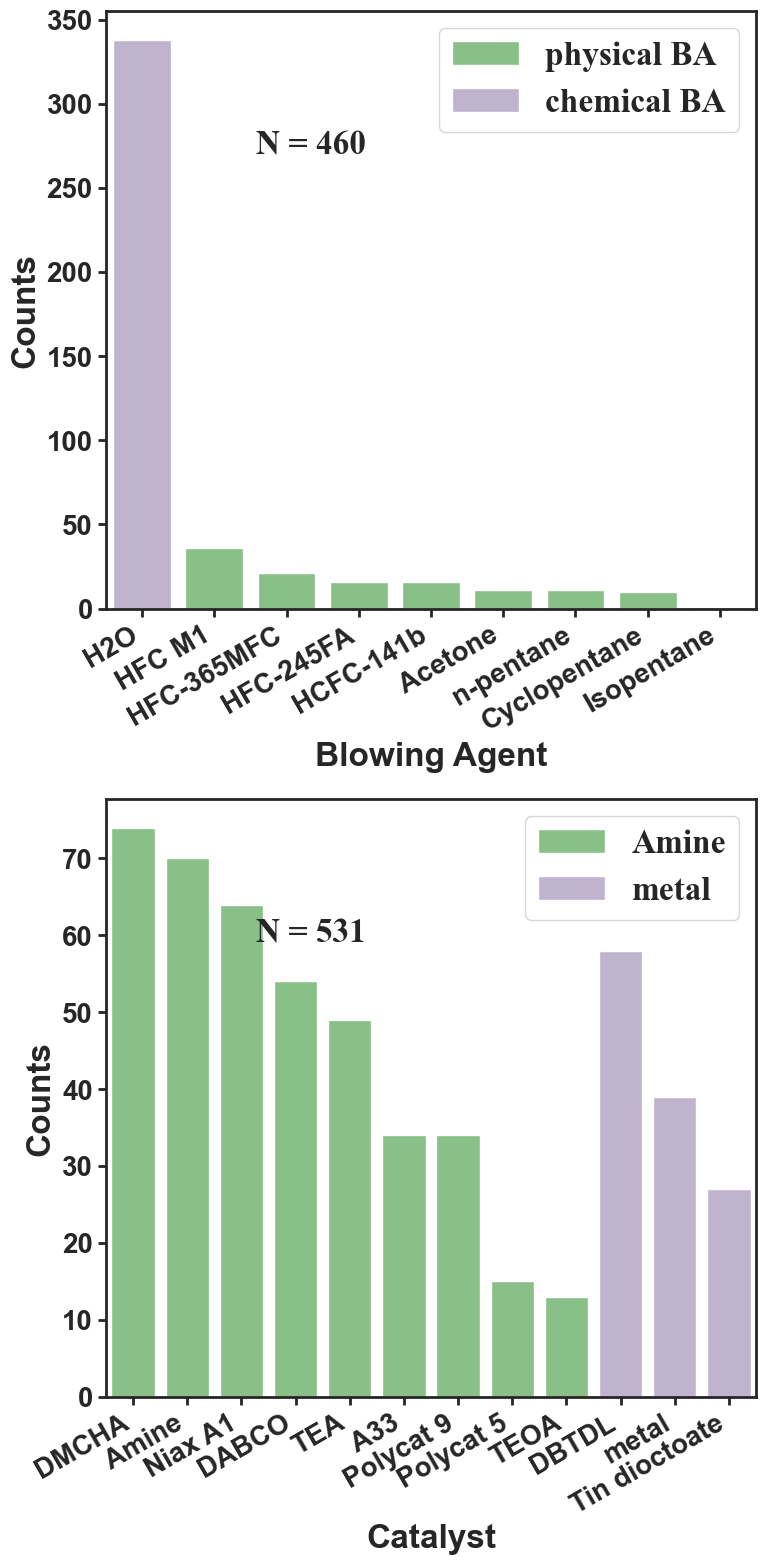

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_excel(r"F:\codes\00-WORK\work-1\01-myself\00-data processing\EXCEL\分布图.xlsx", sheet_name=1)

# 设置风格
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 18
sns.set_style("ticks")

# 排序规则
ba_order = (
    df.groupby(["BA", "BA_Type"]).size()
    .reset_index(name="count")
    .groupby("BA")["count"].max()
    .sort_values(ascending=False)
    .index.tolist()
)
cata_order = (
    df.groupby(['Catalyst_Type', 'Catalyst'])
    .size()
    .reset_index(name='count')
    .sort_values(by=['Catalyst_Type', 'count'], ascending=[True, False])
    ['Catalyst'].tolist()
)

# --- 封装设置函数 ---
def format_axis(ax, xlabel, ylabel, legend_title, n_value):
    ax.set_xlabel(xlabel, fontsize=24, weight='bold')
    ax.set_ylabel(ylabel, fontsize=24, weight='bold')
    ax.text(0.4, 0.8, f'N = {n_value}', transform=ax.transAxes,
            fontsize=24, fontweight='bold', fontname='Times New Roman',
            ha='right', va='top')
    
    # 坐标轴标签
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
        label.set_fontsize(20)
        label.set_weight('bold')
    for label in ax.get_yticklabels():
        label.set_fontsize(20)
        label.set_weight('bold')
    
    # 边框与刻度
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2)
    
    # 图例格式
    legend = ax.legend(title=legend_title, title_fontsize=24, fontsize=24)
    legend.get_title().set_fontweight('bold')
    legend.get_title().set_fontname('Times New Roman')
    for text in legend.get_texts():
        text.set_fontweight('bold')
        text.set_fontname('Times New Roman')

# --- 创建子图 ---
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

# 子图1：BA
sns.countplot(data=df, x='BA', hue='BA_Type', ax=axes[0], palette='Accent', order=ba_order)
format_axis(axes[0], "Blowing Agent", "Counts", "", df['BA'].notna().sum())
# 子图2：Catalyst
sns.countplot(data=df, x='Catalyst', hue='Catalyst_Type', ax=axes[1], palette='Accent', order=cata_order)
format_axis(axes[1], "Catalyst", "Counts", "", df['Catalyst'].notna().sum())
plt.tight_layout()
plt.savefig(r"F:\codes\00-WORK\work-1\01-myself\00-data processing\00-figure\组成分布图.JPG", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\1499756282.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette, ax=ax, boxprops=dict(linewidth=1.5, edgecolor='black'))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\1499756282.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette, ax=ax, boxprops=dict(linewidth=1.5, edgecolor='black'))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\1499756282.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

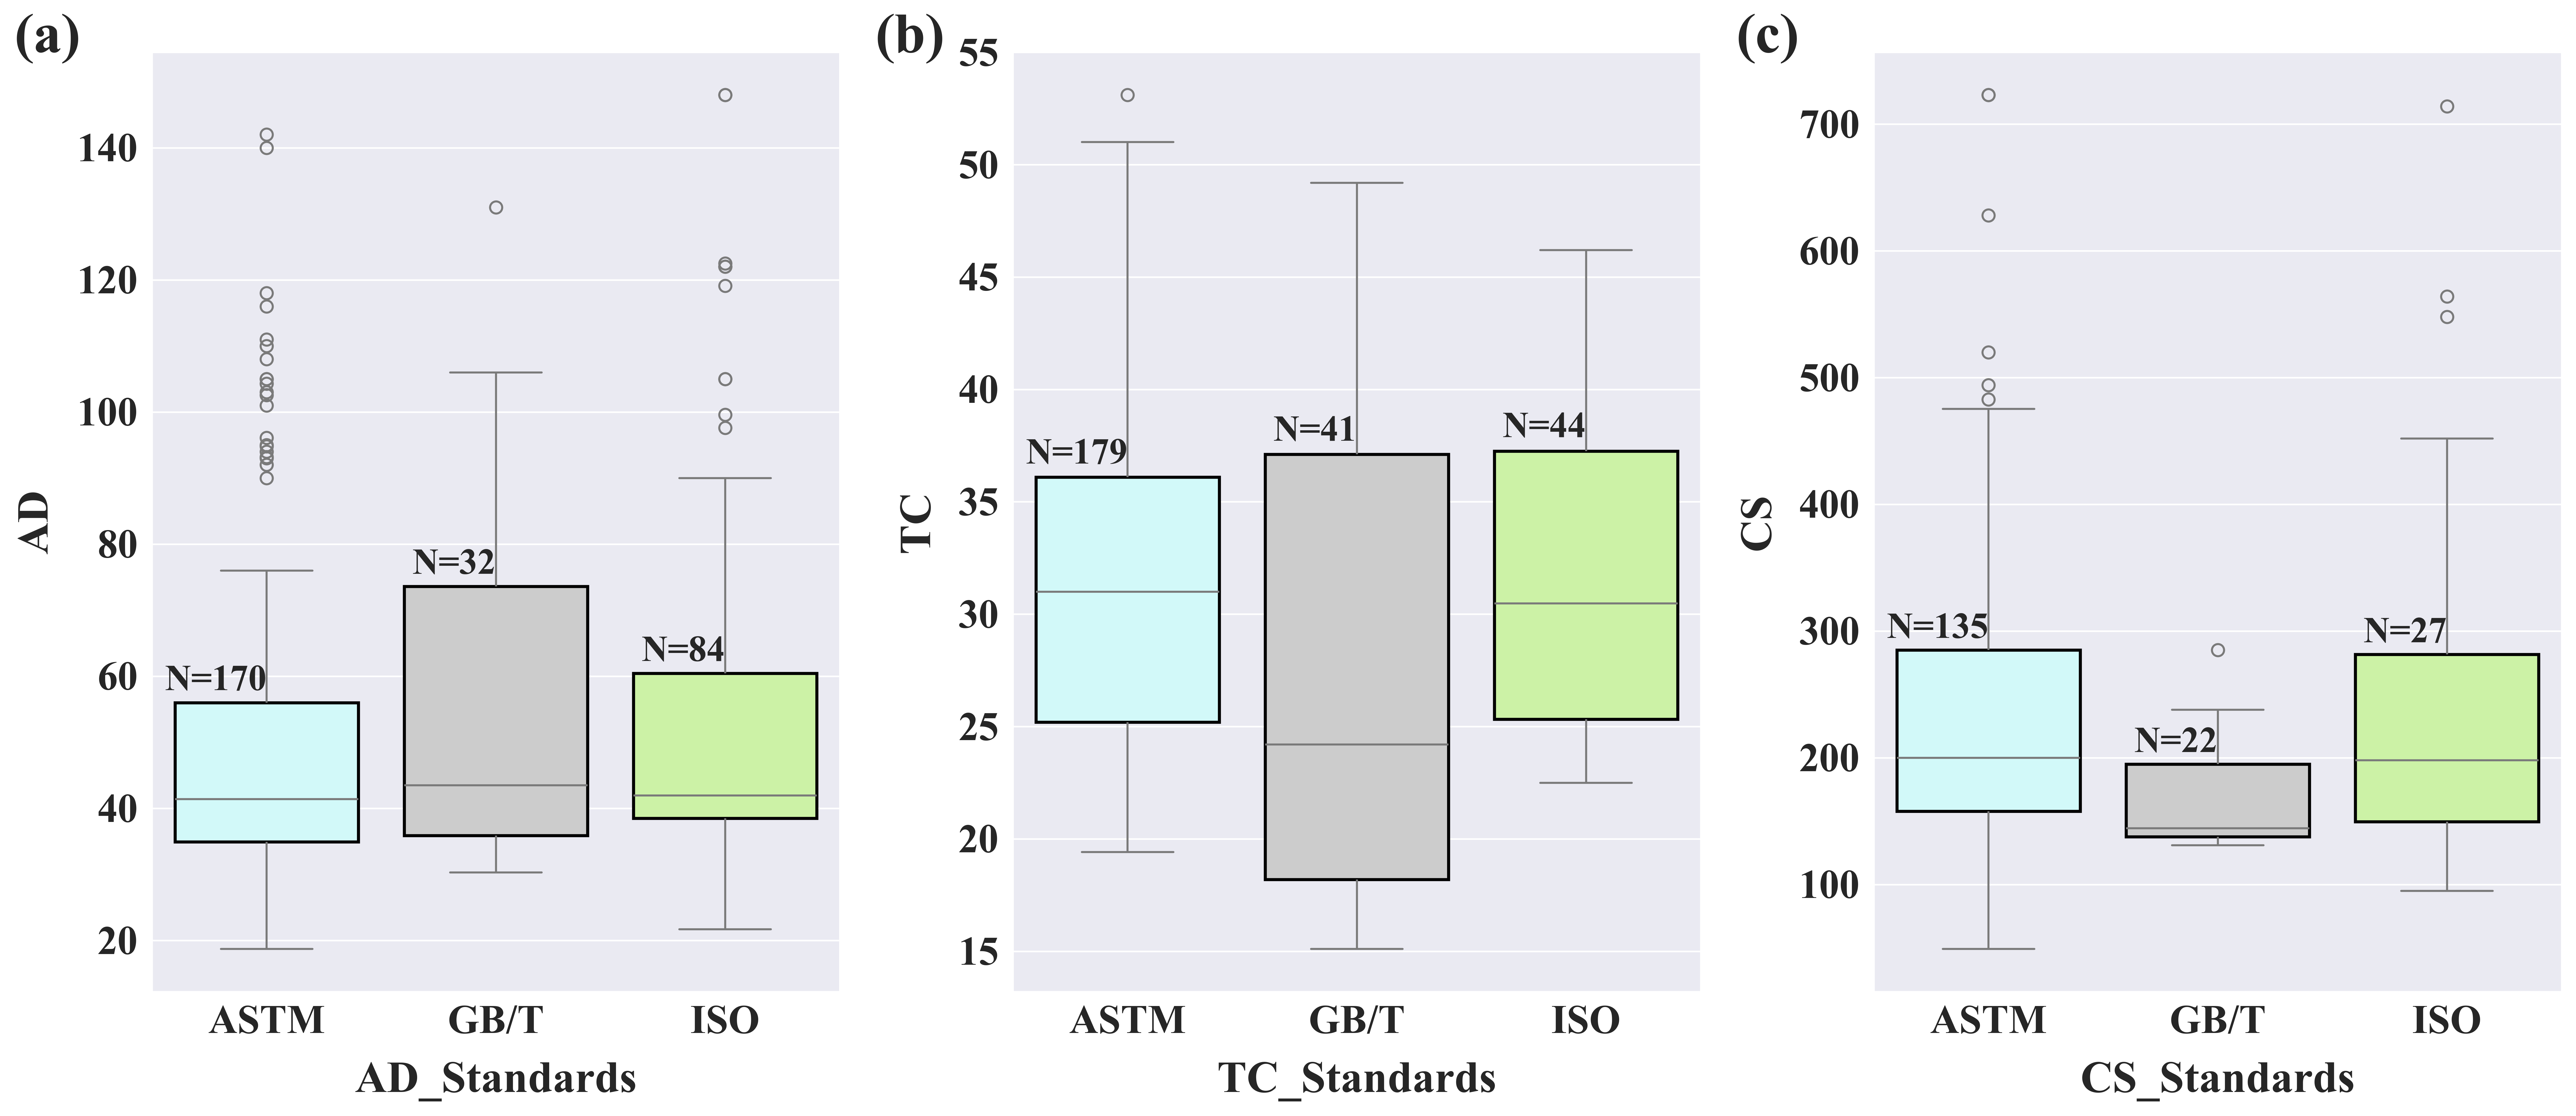

In [9]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# 读取数据
df = pd.read_excel(r"F:/codes/00-WORK/work-1/01-myself/00-data processing/EXCEL/train.xlsx", sheet_name=8)  

# 定义变量
plots = [
      {
        "x": "AD_Standards",
        "y": "AD",
        "order": ['ASTM', 'GB/T', 'ISO'],
        "initial_offset": 0.005,
        "fixed_height_interval": 0.01,
        "ylabel": "AD"
    },
     {
        "x": "TC_Standards",
        "y": "TC",
        "order": ['ASTM',  'GB/T', 'ISO'],
        "initial_offset": 0.001,
        "fixed_height_interval": 0.005,
        "ylabel": "TC"
    },
     {
        "x": "CS_Standards",
        "y": "CS",
        "order": ['ASTM', 'GB/T', 'ISO'],
        "initial_offset": 30,
        "fixed_height_interval": 50,
        "ylabel": "CS"
    }
]
# 设置主题
sns.set_style("darkgrid")
# palette = sns.color_palette("flag")
palette = ["#CCFFFF", "#CCCCCC", "#CCFF99"] 

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 8), facecolor="w",dpi=600)

# 定义函数以根据 p 值返回星号标记
def get_star_annotation(pvalue):
    if pvalue <= 1.00e-04:
        return "****"
    elif pvalue <= 1.00e-03:
        return "***"
    elif pvalue <= 1.00e-02:
        return "**"
    elif pvalue <= 5.00e-02:
        return "*"
    else:
        return "ns"

# 子图序号列表
subplot_labels = ['(a)', '(b)', '(c)']

# 遍历变量绘制箱线图
for idx, (ax, plot) in enumerate(zip(axes, plots)):
    x, y, order = plot["x"], plot["y"], plot["order"]

    # 生成所有可能的组对
    pairs = list(itertools.combinations(order, 2))
    significant_pairs = []

    # 显著性检验
    for group1, group2 in pairs:
        data1 = df[df[x] == group1][y]
        data2 = df[df[x] == group2][y]
        if len(data1) > 1 and len(data2) > 1:
            _, pvalue = mannwhitneyu(data1, data2, alternative='two-sided')
            if pvalue < 0.05:
                significant_pairs.append((group1, group2, pvalue))

    # 箱线图
    sns.boxplot(data=df, x=x, y=y, order=order, palette=palette, ax=ax, boxprops=dict(linewidth=1.5, edgecolor='black'))

    # 当前子图 y 最大值（仅限于实际参与绘图的数据）
    y_max_data = df[df[x].isin(order)][y].max()  
    base_offset = y_max_data * 0.05
    interval = y_max_data * 0.03

    # 添加样本数量
    for i, category in enumerate(order):
        count = df[df[x] == category].shape[0]
        upper_quartile = df[df[x] == category][y].quantile(0.75)
        y_position = upper_quartile + 0.005 * y_max_data
        ax.text(i, y_position, f'N={count}', ha='right', va='bottom',
                fontsize=18, fontweight='bold', fontfamily='Times New Roman')

    # 添加显著性标注
    for i, (group1, group2, pvalue) in enumerate(significant_pairs):
        x1 = order.index(group1)
        x2 = order.index(group2)
        y_min = y_max_data + base_offset + i * interval
        line_height = interval * 0.3
        text_height = interval * 0.0000005

        ax.plot([x1, x1, x2, x2],
                [y_min, y_min + line_height, y_min + line_height, y_min],
                lw=1.5, color='black')

        annotation = get_star_annotation(pvalue)
        ax.text((x1 + x2) * 0.5, y_min + text_height, annotation,
                ha='center', va='bottom', color='black',
                fontsize=18, fontweight="bold")

    # 添加子图标签
    ax.text(-0.2, 1.0, subplot_labels[idx], transform=ax.transAxes,
            fontsize=28, fontweight='bold', fontfamily='Times New Roman')

    # 设置轴标签
    ax.set_xlabel(x, fontsize=22, fontweight="bold", labelpad=10, fontfamily='Times New Roman')
    ax.set_ylabel(plot["ylabel"], fontsize=22, fontweight="bold", labelpad=10, fontfamily='Times New Roman')

    # 设置刻度
    plt.setp(ax.get_xticklabels(), fontsize=20, fontweight="bold", rotation=0, ha='center', fontfamily='Times New Roman')
    plt.setp(ax.get_yticklabels(), fontsize=20, fontweight="bold", fontfamily='Times New Roman')
# 自动布局
plt.tight_layout()
plt.savefig(r"F:\codes\00-WORK\work-1\01-myself\00-data processing\00-figure\标准分布图.JPG", dpi=600, bbox_inches='tight')

plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\639477658.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


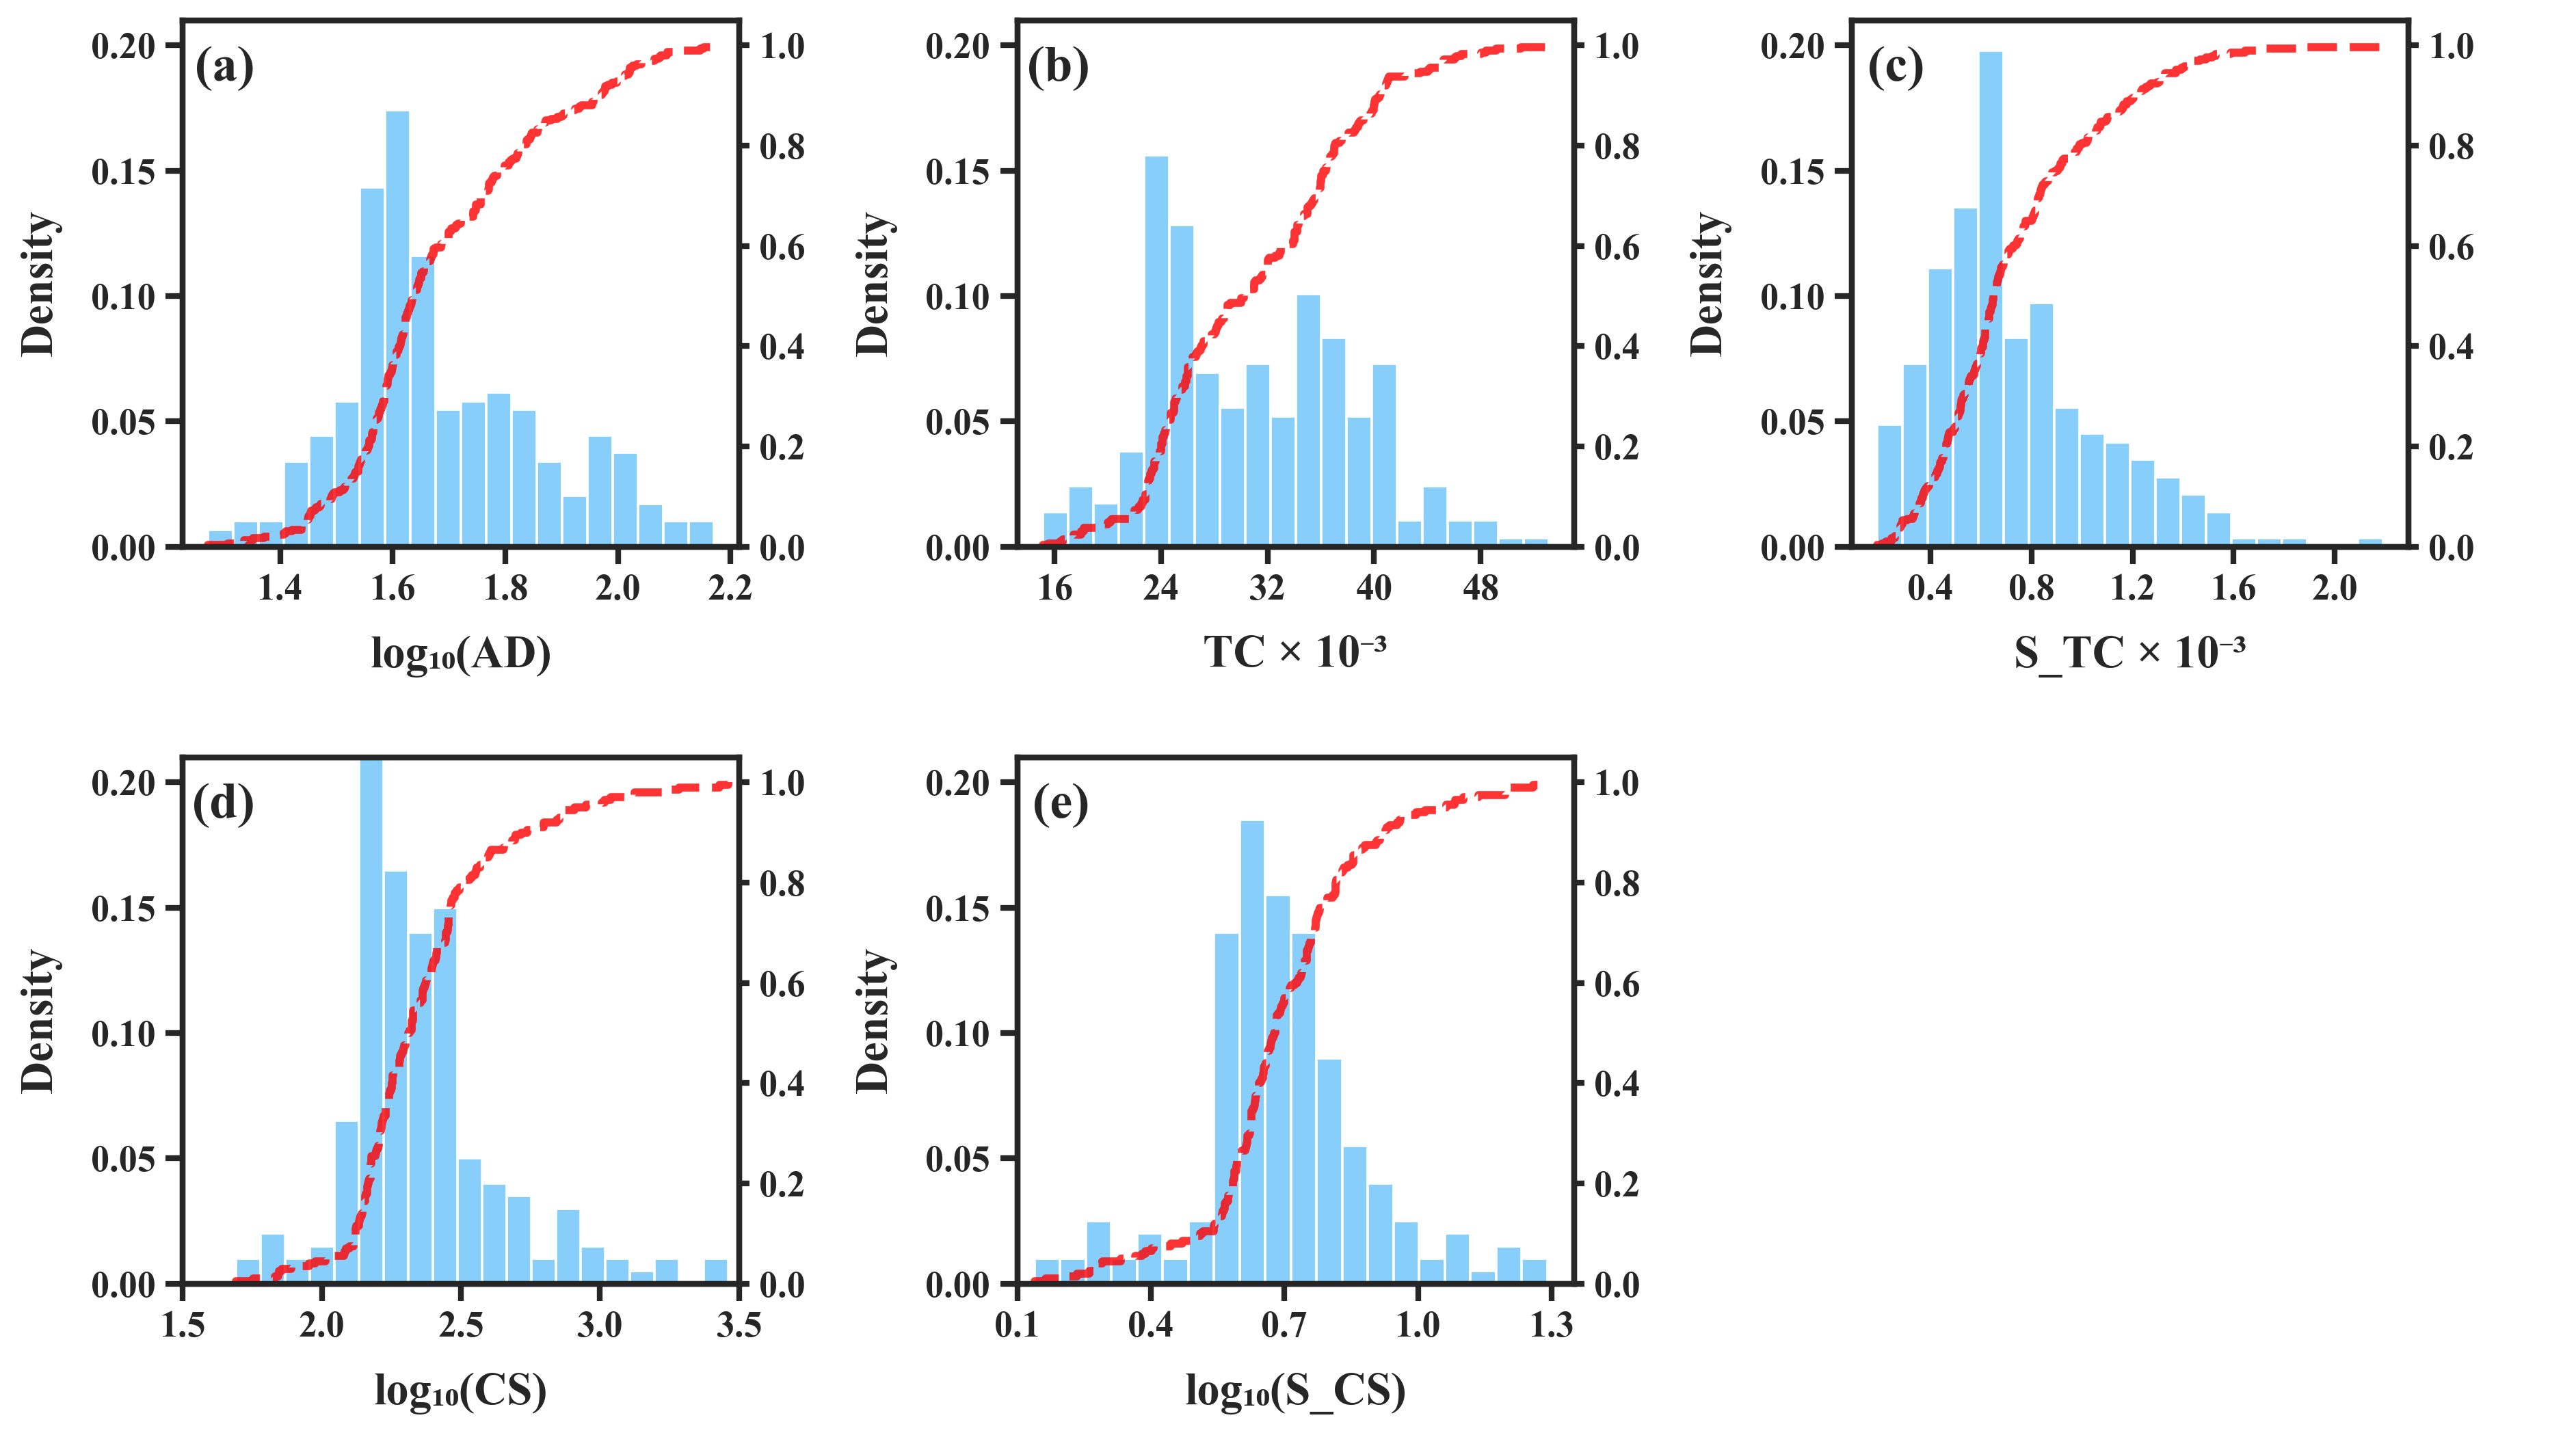

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import numpy as np

# 设置风格
plt.style.use('default')
sns.set_style("white")
plt.rcParams['font.family'] = 'Times New Roman'

# 读取数据
file_path = "F:/codes/00-WORK/work-1/01-myself/00-data processing/EXCEL/train.xlsx"
df_list = [pd.read_excel(file_path, sheet_name=i, dtype={'Catalyst _Code': str}) for i in range(5)]

# 各sheet的配置
sheet_configs = [
    {"df": df_list[0], "x": "AD"},
    {"df": df_list[3], "x": "TC"},
    {"df": df_list[4], "x": "S_TC"},
    {"df": df_list[1], "x": "CS"},
    {"df": df_list[2], "x": "S_CS"}
]

log10_cols = ["AD", "CS", "S_CS"]
subplot_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]

# 创建子图布局 2行3列
fig = plt.figure(figsize=(14, 8), dpi=300)
gs = gridspec.GridSpec(2, 3, wspace=0.5, hspace=0.4)

# 分配5个子图
axes = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(5)]

for i, (config, ax_hist) in enumerate(zip(sheet_configs, axes)):
    df = config["df"]
    x_col = config["x"]

    # log10 转换
    if x_col in log10_cols:
        x_data = np.log10(df[x_col].replace(0, np.nan).dropna())
        x_label = x_col.replace('m3', 'm³')
        x_label = f"log₁₀({x_col})"
    elif x_col == "TC":
        x_data = df[x_col].dropna()
        x_label = "TC × 10⁻³"
    elif x_col == "S_TC":
        x_data = df[x_col].replace(0, np.nan).dropna()
        x_label = "S_TC × 10⁻³"
    else:
        x_data = df[x_col].dropna()
        x_label = x_col.replace('m3', 'm³')


    # 直方图
    sns.histplot(x_data, ax=ax_hist, color="#87CEFA", bins=20, alpha=1, stat="probability", kde=False)
    ax_hist.set_xlabel(x_label, fontsize=16, weight='bold', labelpad=10)
    ax_hist.set_ylabel("Density", fontsize=16, weight='bold', labelpad=10)
    ax_hist.set_ylim(0, 0.21)  # 主轴Y轴范围
    # 设置y轴刻度标签个数
    ax_hist.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # 加粗刻度线
    ax_hist.tick_params(axis='both', which='both', direction='out', length=6, width=2,
                        bottom=True, left=True, top=False, right=False)
    ax_hist.xaxis.set_major_locator(MaxNLocator(nbins=6))
  #设置第4个子图的x轴范围
    if i == 3:  # 第4个子图
        ax_hist.set_xlim(1.5, 3.5)  # 设置x轴范围
        ax_hist.set_xticks([1.5, 2.0, 2.5, 3.0, 3.5])  # 控制刻度位置
    for label in ax_hist.get_xticklabels() + ax_hist.get_yticklabels():
        label.set_fontsize(13)
        label.set_fontweight('bold')
  #设置第5个子图的x轴范围
    if i == 4:  # 第4个子图
        ax_hist.set_xlim(0.1, 1.35)  # 设置x轴范围
        ax_hist.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3])  # 控制刻度位置
    for label in ax_hist.get_xticklabels() + ax_hist.get_yticklabels():
        label.set_fontsize(13)
        label.set_fontweight('bold')
    # 添加子图标签
    ax_hist.text(0.13, 0.95, subplot_labels[i], transform=ax_hist.transAxes,
                 fontsize=18, fontweight='bold', va='top', ha='right')

    # ECDF 曲线
    ax_cdf = ax_hist.twinx()
    sns.ecdfplot(x_data, ax=ax_cdf, color="#FF0000", linewidth=2.8, alpha=0.8, linestyle='--')
    ax_cdf.set_ylabel("  ", fontsize=15, weight='bold', labelpad=15)

    ax_cdf.tick_params(axis='y', labelsize=13, width=2, direction='out')
    ax_cdf.tick_params(axis='x', bottom=False, top=False)  # 关闭右轴横坐标刻度，避免覆盖

    for label in ax_cdf.get_yticklabels():
        label.set_fontweight('bold')

    ax_cdf.set_ylim(0, 1.05)

    # 加粗边框
    for spine in ax_hist.spines.values():
        spine.set_linewidth(2)
    for spine in ax_cdf.spines.values():
        spine.set_linewidth(2)

# 最后一个格子空白
ax_blank = fig.add_subplot(gs[1, 2])
ax_blank.axis('off')

plt.tight_layout()
plt.savefig("F:/codes/00-WORK/work-1/01-myself/00-data processing/00-figure/直方图和ECDF.JPG", dpi=600, bbox_inches='tight')
plt.show()


In [11]:
df = pd.read_excel(r"F:/codes/00-WORK/work-1/01-myself/00-data processing/EXCEL/train.xlsx", sheet_name=5)  # 读取第一个sheet的数据

desc = df.describe()
#计算偏度，峰度，方差
skewness = df.skew()
kurtosis = df.kurtosis()
variance = df.var()

# 将偏度，峰度，方差加入描述性统计表中
desc.loc['skewness'] = skewness
desc.loc['kurtosis'] = kurtosis
desc.loc['variance'] = variance
 
#保留两位小数
desc = desc.round(2)
desc.T

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,variance
AD,293.0,52.85,24.34,18.70,37.12,43.40,62.00,148.00,1.50,1.97,592.39
TC,288.0,30.82,7.45,15.10,24.59,30.22,36.22,53.10,0.33,-0.50,55.52
S_TC,288.0,0.73,0.33,0.19,0.50,0.65,0.89,2.19,1.06,1.32,0.11
CS,200.0,306.63,355.76,49.10,151.00,206.05,290.20,2890.00,4.61,25.99,126563.80
S_CS,200.0,5.48,2.77,1.38,3.98,4.76,6.03,19.53,2.28,7.08,7.69


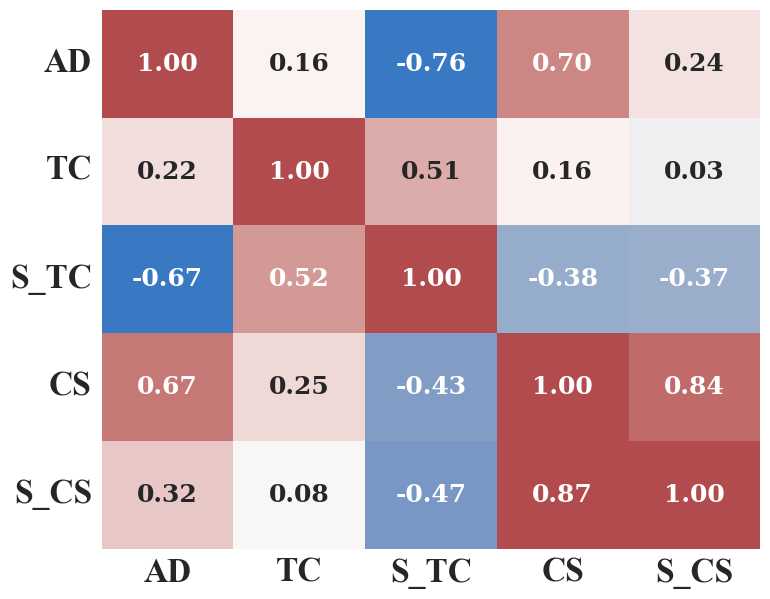

In [12]:
import pandas  as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import numpy as np
import os

df = pd.read_excel(r"F:/codes/00-WORK/work-1/01-myself/00-data processing/EXCEL/train.xlsx", sheet_name=5)  # 读取第一个sheet的数据

plt.rc('font',family='serif',size=10,weight="bold")#再用plt.rc对全图
plt.figure(figsize=(8.5,7))
# 计算相关系数矩阵
corr_s = df.corr('spearman')
corr_p = df.corr()

# 生成掩码以将上下半三角分开
mask_upper = np.tril(np.ones(corr_p.shape), k=-1).astype(bool)
mask_lower = np.triu(np.ones(corr_s.shape), k=0).astype(bool)
# 设置颜色透明度

h= sns.heatmap(corr_s, mask=mask_upper, cmap="vlag", alpha=0.9, annot=True, fmt='.2f',cbar=False, annot_kws={"size": 18})
h= sns.heatmap(corr_p, mask=mask_lower, cmap="vlag", alpha=0.9, annot=True, fmt='.2f',cbar=False, annot_kws={"size": 18})
# cb = h.figure.colorbar(h.collections[0]) #显示colorbar
# cb.ax.tick_params(labelsize=18)  # 设置colorbar刻度字体大小。

sns.set(font_scale=1.5)#先用sns.set(font_scale)修改字体比例

plt.xticks(fontsize=24,rotation = 0,weight="bold", fontfamily='Times New Roman')
plt.yticks(fontsize=24,rotation = 0,weight="bold", fontfamily='Times New Roman')

plt.rcParams['savefig.dpi'] = 300
plt.savefig(os.path.join(folder_path, 'test.JPG'), dpi=600)
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\947823863.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\947823863.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\947823863.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23516\947823863.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax

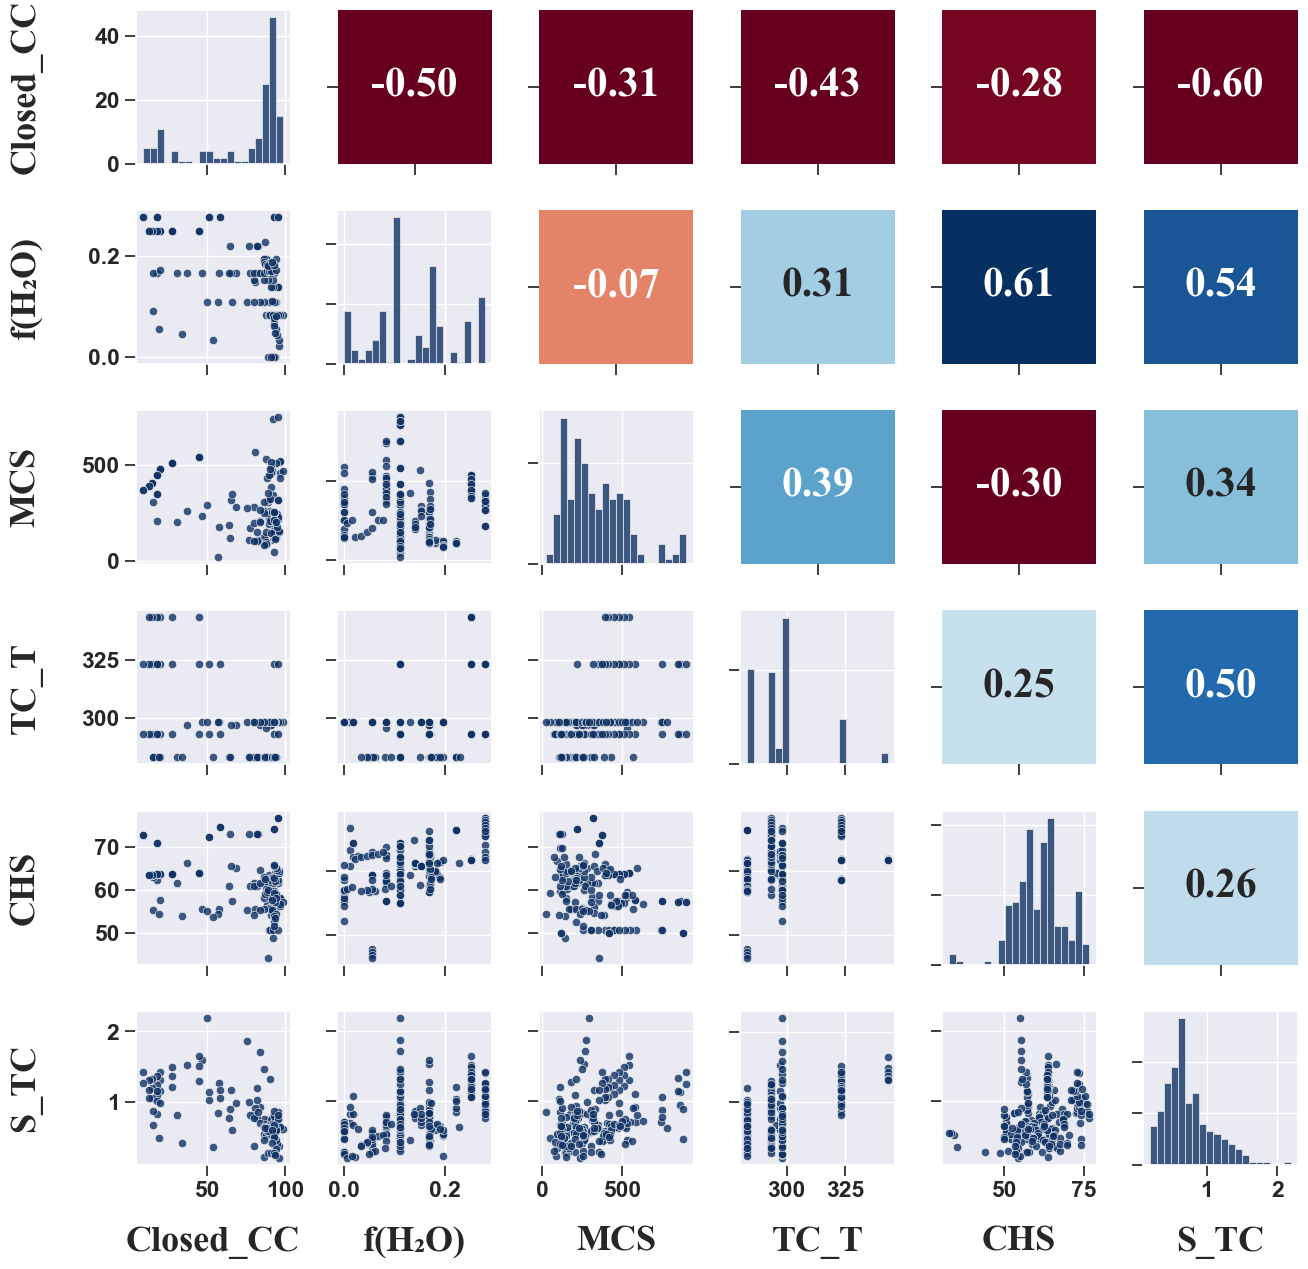

In [13]:
from matplotlib import rc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import os

file_path = r"F:\codes\00-WORK\work-1\01-myself\00-data processing\EXCEL\相关矩阵.xlsx"

# 读取数据并强制 Catalyst _Code 列为字符串
df_list = []
for i in range(5):
    data = pd.read_excel(file_path, sheet_name=4, dtype={'Cata_Code': str})
    df_list.append(data)
    data = data.dropna(subset=['S_TC'])

corr = data.corr()
n = len(data.columns)
fig, axes = plt.subplots(n, n, figsize=(2.5 * n, 2.5 * n))

# 设置绘图样式和字体
plt.style.use('bmh')
plt.rc('font', weight='bold')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24
rc('font', family='Times New Roman')
rc('mathtext', fontset='custom', rm='Times New Roman', it='Times New Roman:italic', bf='Times New Roman:bold')

# 定义标题顺序并替换 f(H2O) -> f(H₂O)，m3 -> m³
titles = data.columns.str.replace("m3", "m³", regex=False).str.replace("f(H2O)", "f(H₂O)", regex=False)
# 绘制每个位置的散点图和直方图
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 对角线：绘制直方图
            sns.histplot(data.iloc[:, i], bins=20, kde=False,color='#0F3163', alpha=0.8, ax=ax)
        elif i > j:
            # 下三角：绘制散点图
            sns.scatterplot(x=data.iloc[:, j], y=data.iloc[:, i],color='#0F3163', alpha=0.8, ax=ax)
        else:
            # 上三角：绘制热图显示相关系数
            sns.heatmap(pd.DataFrame([[corr.iloc[i, j]]]), cmap="RdBu",
                        cbar=False, annot=True, fmt=".2f", square=True, ax=ax, vmin=-0.3, vmax=0.6,
                        annot_kws={"size": 30})  # 设置相关系数数字字体大小

        # 隐藏不需要的轴刻度标签
        if i < n - 1:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

        # 隐藏不需要的坐标轴标题，只保留最左边和最下方的标题
        if j > 0:  # 隐藏不是最左边的子图的y轴标题
            ax.set_ylabel('')
        if i < n - 1:  # 隐藏不是最下方的子图的x轴标题
            ax.set_xlabel('')
         # 设置坐标轴标题
        if j == 0:  # 最左边的列
            ax.set_ylabel(titles[i], fontsize=26, fontname='Times New Roman', weight='bold')
            #设置坐标轴标题位置
            ax.yaxis.set_label_coords(-0.6, 0.5)
        if i == n - 1:  # 最下边的行
            ax.set_xlabel(titles[j], fontsize=26, fontname='Times New Roman', weight='bold')
            #设置坐标轴标题位置
            ax.xaxis.set_label_coords(0.5, -0.4)
        ax.minorticks_on()
        ax.tick_params(which='minor', length=5, color='gray', direction='out')  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=8, direction='out')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.savefig(os.path.join(r'F:\codes\00-WORK\work-1\01-myself\00-data processing\00-figure\S_TC_Top5.JPG'), dpi=600, bbox_inches='tight')
plt.show()